# Install Dependencies and Setup

In [4]:
# what version of Python do you have?
import sys
import os

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

# check whether the GPU is available
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


Python Platform: macOS-13.1-arm64-arm-64bit
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.1
GPU is available


In [5]:
# additional ibraries for tensorflow image cassification tasks
import pathlib # object-oriented filesystem paths
import matplotlib.pyplot as plt
import numpy as np
import PIL # python imaging library for image processing capabilities

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



# Explore the Datasets

## Image Dataset

In [3]:
# get current working directory
current_dir = os.getcwd()
current_dir

'/Users/marcdeheeger/PythonProjects/MSDS 498/Mushroom Project/Master'

In [4]:
# create pathlib.PosixPath object for directory containing images
data_dir = 'data/images/mushroom_images' # put in path to your image directory in place here
data_dir = pathlib.Path(data_dir)

In [5]:
data_dir

PosixPath('data/images/mushroom_images')

In [6]:
os.listdir(data_dir)

['king bolete - Google Search - 2_25_2023 4-52-16 PM',
 'cantharellus cibarius - Google Search - 2_23_2023 12-04-53 PM',
 'anmanita muscaria - Google Search - 2_23_2023 11-37-51 AM']

In [7]:
# number of images in the image directory
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

444


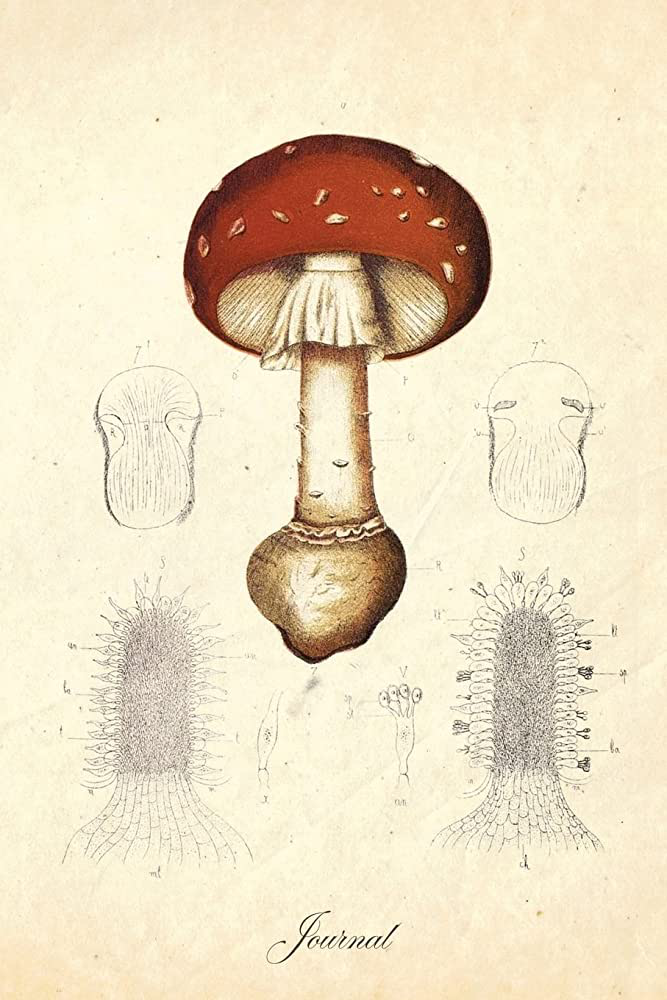

In [8]:
# example image
amanita_muscaria = list(data_dir.glob('anmanita muscaria - Google Search - 2_23_2023 11-37-51 AM/*'))
PIL.Image.open(str(amanita_muscaria[0]))

## Prepare image dataset

### Image dataset generation using new image_dataset_from_directory Feature of Tensorflow 2.0

In [11]:
batch_size = 32
img_height = 250
img_width = 250

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 416 files belonging to 3 classes.
Using 333 files for training.
Metal device set to: Apple M1 Max


2023-03-03 09:02:51.569292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-03 09:02:51.569504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 416 files belonging to 3 classes.
Using 83 files for validation.


In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

2023-03-03 09:02:52.858035: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(32, 250, 250, 3)
(32,)


In [15]:
class_names = train_ds.class_names
print(class_names)

['anmanita muscaria - Google Search - 2_23_2023 11-37-51 AM', 'cantharellus cibarius - Google Search - 2_23_2023 12-04-53 PM', 'king bolete - Google Search - 2_25_2023 4-52-16 PM']


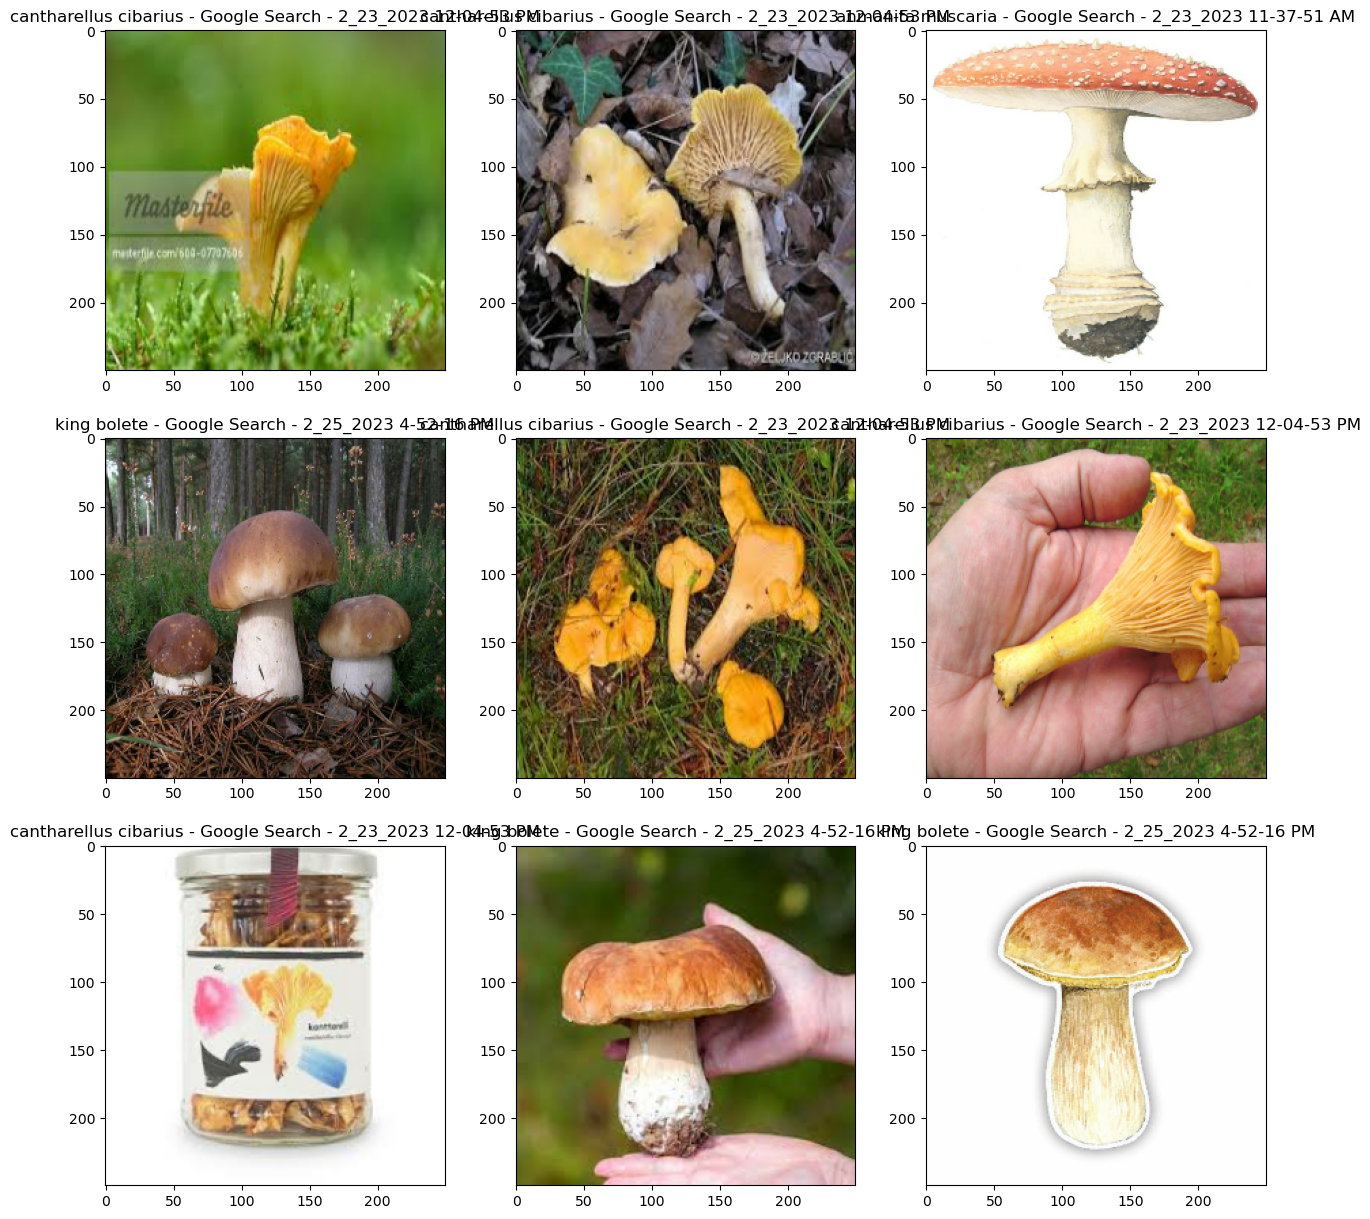

In [110]:
plt.figure(figsize = (15,15))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('on')

In [126]:
x_images = []
y_labels = []
for images, labels in train_ds.take(1):
    x_images.append(images)
    y_labels.append(labels)
     
    

In [129]:
x_images

[<tf.Tensor: shape=(32, 250, 250, 3), dtype=float32, numpy=
 array([[[[2.61440010e+01, 3.01440010e+01, 5.14400005e+00],
          [3.45400009e+01, 3.84860001e+01, 1.37020006e+01],
          [4.43600006e+01, 4.73600006e+01, 2.63600006e+01],
          ...,
          [2.50899963e+01, 2.16400146e+01, 1.31799927e+01],
          [3.63521729e+01, 3.80822449e+01, 2.52981873e+01],
          [4.78019409e+01, 4.98019409e+01, 3.68019409e+01]],
 
         [[3.27840004e+01, 3.67840004e+01, 1.17840004e+01],
          [4.11082878e+01, 4.50901451e+01, 2.02344322e+01],
          [4.94927216e+01, 5.30969620e+01, 3.08884811e+01],
          ...,
          [2.36424809e+01, 2.20052261e+01, 1.41494474e+01],
          [4.00494003e+01, 4.18870125e+01, 3.03951092e+01],
          [5.56982079e+01, 5.76982079e+01, 4.60262070e+01]],
 
         [[4.05360794e+01, 4.45360794e+01, 1.86560802e+01],
          [4.83444824e+01, 5.23444824e+01, 2.65249615e+01],
          [5.50512009e+01, 5.90008011e+01, 3.44207993e+01],
    

In [128]:
y_labels

[<tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([2, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 0, 1, 0, 1, 1,
        2, 0, 1, 1, 0, 0, 0, 2, 1, 1], dtype=int32)>]

In [122]:
x_images

[<tf.Tensor: shape=(32, 250, 250, 3), dtype=float32, numpy=
 array([[[[8.30000043e-01, 2.82999992e+00, 1.83000004e+00],
          [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 1.15000057e+00, 1.50000572e-01],
          ...,
          [1.14539680e+01, 1.53618898e+01, 7.06077456e-01],
          [2.88682632e+01, 3.26402626e+01, 1.32542629e+01],
          [2.17484512e+01, 2.63624516e+01, 7.52045155e+00]],
 
         [[8.30000043e-01, 2.82999992e+00, 1.83000004e+00],
          [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 1.86570013e+00, 8.65700126e-01],
          ...,
          [3.62148514e+01, 3.83491554e+01, 1.76177673e+01],
          [1.99648571e+01, 1.83814583e+01, 1.37742805e+00],
          [2.48512650e+01, 2.84069099e+01, 6.00926495e+00]],
 
         [[8.30000043e-01, 2.82999992e+00, 1.83000004e+00],
          [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
          [5.94996996e-02, 2.05949974e+00, 1.05949974e+00],
    

## Tabular Data

### Initial datasets

In [22]:
# characteristics of individual species
df_primary = pd.read_csv('data/tabular/primary_data_edited.csv', delimiter=';', header=None)

In [23]:
df_primary.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,family,name,class,cap-diameter,cap-shape,Cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,Spore-print-color,habitat,season
1,Amanita Family,Fly Agaric,p,"[10, 20]","[x, f]","[g, h]","[e, o]",[f],[e],NaN,...,[s],[y],[w],[u],[w],[t],"[g, p]",NaN,[d],"[u, a, w]"
2,Amanita Family,Panther Cap,p,"[5, 10]","[p, x]",[g],[n],[f],[e],NaN,...,NaN,[y],[w],[u],[w],[t],[p],NaN,[d],"[u, a]"
3,Amanita Family,False Panther Cap,p,"[10, 15]","[x, f]",NaN,"[g, n]",[f],[e],NaN,...,NaN,NaN,[w],[u],[w],[t],"[e, g]",NaN,[d],"[u, a]"
4,Amanita Family,The Blusher,e,"[5, 15]","[x, f]",NaN,[n],[t],NaN,NaN,...,[b],NaN,[w],[u],[w],[t],[g],NaN,[d],"[u, a]"


In [24]:
# secondary samples generated from mushroom characteristic parameters
# filtering these out by species according to meta data description that states they are listed in order -- 353 samples per species
df_secondary = pd.read_csv('data/tabular/secondary_data_generated.csv', delimiter=';')

In [25]:
df_secondary.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [26]:
# total number of generated mushrooms
df_secondary.shape

(61069, 21)

In [92]:
df_secondary.iloc[57185]

class                       e
cap-diameter            10.63
cap-shape                   f
cap-surface                 e
cap-color                   b
does-bruise-or-bleed        f
gill-attachment           NaN
gill-spacing                c
gill-color                  b
stem-height              5.04
stem-width               21.3
stem-root                 NaN
stem-surface              NaN
stem-color                  w
veil-type                 NaN
veil-color                NaN
has-ring                    t
ring-type                   f
spore-print-color         NaN
habitat                     d
season                      a
Name: 57185, dtype: object

cap_diameter = []
cap_shape = []
cap_surface = 
cap_color = 
does_bruise_bleed = 
gill_attachment = 
gill_spacing = 
gill_color = 
stem_height = 
stem_width = 
stem_root = 
stem_surface = 
stem_color = veil_type = 
has_ring = 
ring_type = 
spore_print_color = 
habitat = 
season = 

### Selecting data for training

In [27]:
# only using subset of total species
# these represent the rows of certain species
df_selected_species = df_secondary.loc[np.r_[0:353, 48362:48715, 54362:54715,  ], :]

In [78]:
# these are the features we are going to isolate for the sake of simplicity
df_selected_data = df_selected_rows[['class','cap-shape', 'cap-color', 'cap-diameter','stem-color']]

In [79]:
df_selected_data['species'] = 'fly agaric'

/var/folders/48/5135ttxs0wn09qqbvdw_6n7r0000gn/T/ipykernel_51570/3518940609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_data['species'] = 'fly agaric'


In [83]:
# edible specimens
df_selected_data['species'][60363:60715] = 'morchella_esculenta' # yellow morel
df_selected_data['species'][:57185] = 'hydnum_repandum' # hedgehog mushroom
df_selected_data['species'][:] = 'cantharellus_cibarius' # chanterelle
df_selected_data['species'][:] = 'boletus_edulis' # penny bun
df_selected_data['species'][:] = 'amanita_citrina' # false deathcap

# poisonous specimens
df_selected_data['species'][:] = 'hebeloma_crustuliniforme' # poison pie
df_selected_data['species'][:] = 'caloboletus_calopus' # bitter beech bolete
df_selected_data['species'][:] = 'ampulloclitocybe_clavipes' # club-footed funnel cap
df_selected_data['species'][:] = 'amanita_phalloides' # death cap
df_selected_data['species'][0:353] = 'amanita_muscaria' # fly agaric


SyntaxError: invalid syntax (2049231346.py, line 2)

In [81]:
df_selected_data['species'].unique()

array(['amanita_muscaria', 'king bolete', 'fly agaric', 'chantarelle'],
      dtype=object)

In [82]:
df_selected_data.head(1)

,class,cap-shape,cap-color,cap-diameter,stem-color,species
0,p,x,o,15.26,w,amanita_muscaria


In [58]:
df_selected_data.to_csv('data/tabular/tabular_data')

In [64]:
df_selected_data.shape

(1059, 6)

In [67]:
df_selected_data.loc[[0,352],:]

,class,cap-shape,cap-color,cap-diameter,stem-color,species
0,p,x,o,15.26,w,amanita_muscaria
352,p,x,o,16.07,w,amanita_muscaria


# Prepare Datasets

## Prepare tabular dataset

### Converting features and labels into numbers

In [43]:
# isolating features from labels
df_selected_X = df_selected_data[['class','cap-shape', 'cap-color', 'cap-diameter','stem-color']]

In [54]:
df_selected_X.loc[[0,4],:]

,class,cap-shape,cap-color,cap-diameter,stem-color
0,p,x,o,15.26,w
4,p,x,o,14.64,w


In [33]:
# one-hot-encoding features
X_ohe = pd.get_dummies(df_selected_X, columns = ['class', 'cap-shape', 'cap-color', 'stem-color'])
print(X_ohe)

       cap-diameter  class_e  class_p  cap-shape_f  cap-shape_p  cap-shape_s  \
0             15.26        0        1            0            0            0   
1             16.60        0        1            0            0            0   
2             14.07        0        1            0            0            0   
3             14.17        0        1            1            0            0   
4             14.64        0        1            0            0            0   
...             ...      ...      ...          ...          ...          ...   
54710          6.52        1        0            1            0            0   
54711          4.88        1        0            1            0            0   
54712          5.09        1        0            0            0            1   
54713          7.28        1        0            0            0            0   
54714          4.17        1        0            0            0            1   

       cap-shape_x  cap-color_e  cap-co

In [34]:
# on to the labels
df_selected_y = df_selected_data[['species']]

In [35]:
df_selected_y.head()

,species
0,fly agaric
1,fly agaric
2,fly agaric
3,fly agaric
4,fly agaric


In [36]:
# converting labels into integers using LabelEncoder
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df_selected_y['species'])
print(integer_encoded)
len(np.unique(integer_encoded))

[1 1 1 ... 0 0 0]


3

In [37]:
label_encoder.classes_

array(['chantarelle', 'fly agaric', 'king bolete'], dtype=object)

In [131]:
y_labels = integer_encoded
y_labels

array([1, 1, 1, ..., 0, 0, 0])

In [136]:
df_y = pd.DataFrame(y_labels)
df_y.to_csv('y_labels')

In [39]:
from sklearn.model_selection import train_test_split

X, y = X_ohe, y_labels

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [41]:
print(X_train.shape)
print(y_train.shape)

(709, 14)
(709,)


# Create Models

## Single Models

### NN Model

In [42]:
X_train.shape[1]

14

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_12 (Dense)            (None, 10)                150       
                                                                 
 dense_13 (Dense)            (None, 20)                220       
                                                                 
 dense_14 (Dense)            (None, 10)                210       
                                                                 
 dense_15 (Dense)            (None, 3)                 33        
                                                                 
Total params: 613
Trainable params: 613
Non-trainable params: 0
_________________________________________________________________
None


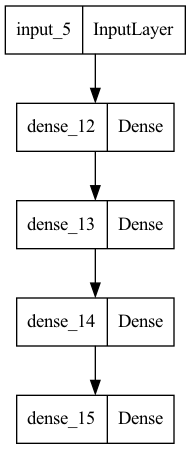

In [47]:
### NN Model for tabular data
input_shape = num_classes = X_train.shape[1]
num_classes = len(np.unique(y_labels))
# Multilayer Perceptron
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense

visible = Input(shape=(input_shape,))
hidden1 = Dense(10, activation='relu')(visible)
hidden2 = Dense(20, activation='relu')(hidden1)
hidden3 = Dense(10, activation='relu')(hidden2)
output = Dense(num_classes, activation='softmax')(hidden3)
model_nn = Model(inputs=visible, outputs=output)
# summarize layers
print(model_nn.summary())
# plot graph
plot_model(model_nn, to_file='multilayer_perceptron_graph.png')

In [48]:
model_nn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
# training single cnn model
epochs=10
history = model_nn.fit(
  X_train, y_train, validation_split=0.2,
  epochs=epochs
)

Epoch 1/10


/Users/marcdeheeger/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 1/18 [>.............................] - ETA: 7s - loss: 1.0881 - accuracy: 0.4375

2023-03-03 09:04:35.301590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 19ms/step - loss: 0.9606 - accuracy: 0.6684 - val_loss: 0.8763 - val_accuracy: 0.6690
Epoch 2/10
 9/18 [==============>...............] - ETA: 0s - loss: 0.8091 - accuracy: 0.6806

/Users/marcdeheeger/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-03-03 09:04:35.688526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 9ms/step - loss: 0.7756 - accuracy: 0.6861 - val_loss: 0.7253 - val_accuracy: 0.6972
Epoch 3/10
18/18 [==============================] - 0s 8ms/step - loss: 0.6458 - accuracy: 0.8272 - val_loss: 0.6008 - val_accuracy: 0.9648
Epoch 4/10
18/18 [==============================] - 0s 9ms/step - loss: 0.5284 - accuracy: 0.9841 - val_loss: 0.4785 - val_accuracy: 1.0000
Epoch 5/10
18/18 [==============================] - 0s 9ms/step - loss: 0.4167 - accuracy: 1.0000 - val_loss: 0.3742 - val_accuracy: 1.0000
Epoch 6/10
18/18 [==============================] - 0s 9ms/step - loss: 0.3258 - accuracy: 1.0000 - val_loss: 0.2912 - val_accuracy: 1.0000
Epoch 7/10
18/18 [==============================] - 0s 9ms/step - loss: 0.2499 - accuracy: 1.0000 - val_loss: 0.2202 - val_accuracy: 1.0000
Epoch 8/10
18/18 [==============================] - 0s 8ms/step - loss: 0.1885 - accuracy: 1.0000 - val_loss: 0.1650 - val_accuracy: 1.0000
Epoch 9/10
18/18 [=============

### CNN Model

In [51]:

# Multiple Inputs
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

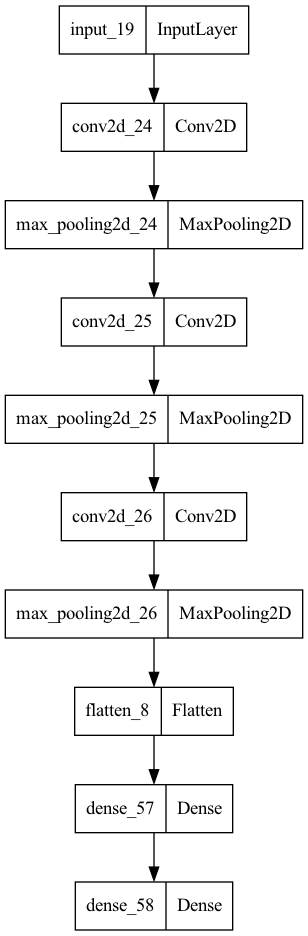

In [63]:
# images cnn model

num_classes = len(class_names)

cnn = Input(shape=(250, 250, 3))
# x = Rescaling(1./255, input_shape=(img_height, img_width, 3))
x = Conv2D(16, 3, padding='same', activation='relu')(cnn)
x = MaxPooling2D()(x)
x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes)(x)

model_cnn = Model(inputs=cnn, outputs=x)
plot_model(model_cnn, to_file='convolutional_neural_network.png')


In [54]:
model_cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [56]:
model_cnn.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 64)        1849

## Dual-input Model

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_60 (Conv2D)             (None, 250, 250, 16  448         ['input_41[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_60 (MaxPooling2D  (None, 125, 125, 16  0          ['conv2d_60[0][0]']              
 )                              )                                                          

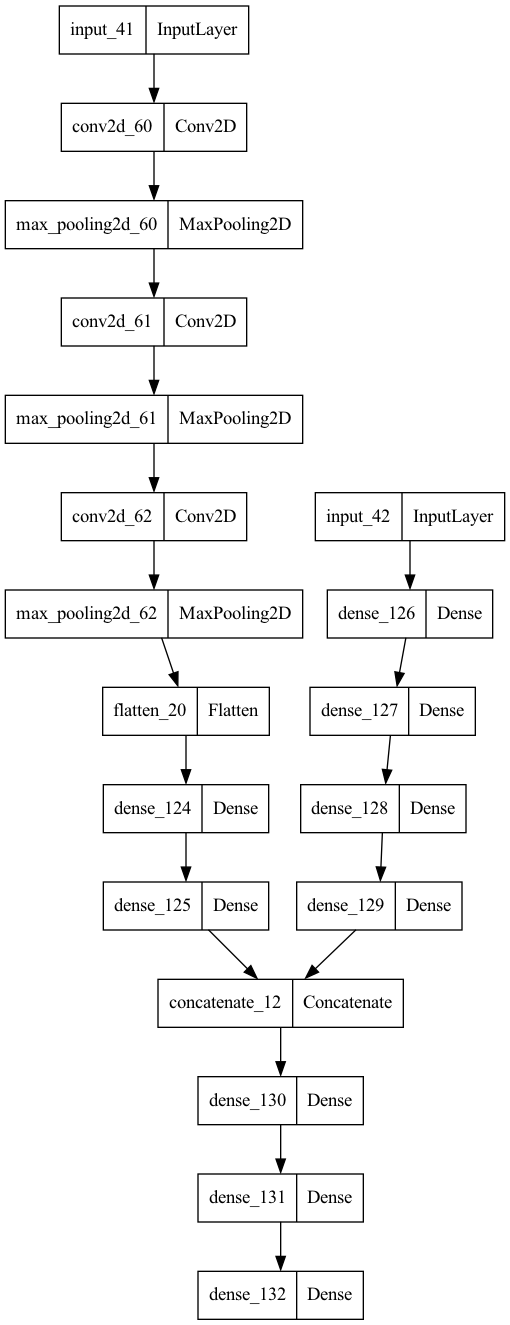

In [ ]:
# requirements for dual-input model
from tensorflow.keras.models import Model
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense

from keras.layers import concatenate

# FIRST INPUT MODEL
# images cnn model
num_classes_cnn = len(class_names)

dual_cnn = Input(shape=(250, 250, 3))
# x = Rescaling(1./255, input_shape=(img_height, img_width, 3))
x = Conv2D(16, 3, padding='same', activation='relu')(dual_cnn)
x = MaxPooling2D()(x)
x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes)(x)

model_cnn = Model(inputs=dual_cnn, outputs=x)


# SECOND INPUT MODEL
# NN Model for tabular data
input_shape_nn = X_train.shape[1]
num_classes_nn = len(np.unique(y_labels))

dual_nn = Input(shape=(input_shape_nn,))
hidden1 = Dense(10, activation='relu')(dual_nn)
hidden2 = Dense(20, activation='relu')(hidden1)
hidden3 = Dense(10, activation='relu')(hidden2)
y = Dense(num_classes_nn, activation='softmax')(hidden3)

# model_nn = Model(inputs=visible, outputs=output)

# merge input models
merge = concatenate([y, x])

# interpretation model
hidden1 = Dense(10, activation='relu')(merge)
hidden2 = Dense(10, activation='relu')(hidden1)
output = Dense(1, activation='sigmoid')(hidden2)
model_dual = Model(inputs=[dual_cnn, dual_nn], outputs=output)

# summarize layers
print(model_dual.summary())
# plot graph
plot_model(model_dual, to_file='multiple_inputs.png')


In [ ]:
model_dual.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [178]:
np.asarray(x_images).shape

(1, 32, 250, 250, 3)

In [176]:
# training single cnn model
epochs=10
history = model_dual.fit(
  x = [np.asarray(x_images), X_train[0:31]], y=[y_labels[0:31],y_train[0:31]],
  validation_data=val_ds,
  epochs=epochs
)

ValueError: Data cardinality is ambiguous:
  x sizes: 1, 31
  y sizes: 31, 31
Make sure all arrays contain the same number of samples.

In [148]:

x_images[0:32]
X_train[0:32]
y_labels[0:32]
# y_train[0:32]

array([1, 2, 1, 0, 2, 2, 1, 0, 0, 2, 0, 1, 0, 2, 2, 0, 2, 2, 2, 1, 1, 2,
       0, 1, 1, 2, 2, 0, 2, 2, 2, 2])

# Train Models

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

## Review Model Performance

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 7. Train

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
pip install tensorflow-macos==2.10

In [ ]:
pip install tensorflow-metal==0.6

In [ ]:
train[0]

In [ ]:
with tf.device('/device:GPU:0'):
    hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
train

In [ ]:
with tf.device('/cpu:0'):
    hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
with tf.device('/device:GPU:0'):
    model.fit(x_train, y_train)

In [ ]:
train

# PLAYGROUND

In [ ]:
import random

In [ ]:
random.seed(123)
random.random()

In [ ]:
random.randint(10,100)

In [ ]:
random.uniform(10,100)

In [ ]:
import numpy as np
stem_color = ('green', 'red', 'blue')
np.random.choice(stem_color)